# Matchup satellite data to ship, glider, or animal tracks

> history | Modified August 2023  

## Overview

In this exercise you will extract satellite data around a set of points defined by longitude, latitude, and time coordinates, like that produced by an animal telemetry tag, and ship track, or a glider tract.

Please note that there are more efficient ways, more Pythonic ways, to accomplish the tasks in this tutorial. The tutorial was developed to be easier to follow for less experienced users of Python.

### The exercise demonstrates the following techniques:

* Loading data from a tab- or comma-separated file
* Plotting the latitude/longitude points onto a map 
* Extracting satellite data along a track
* Building an ERDDAP data-request URL
* Saving results as a CSV file
* Plotting the satellite data onto a map  

### Datasets used:
- Chlorophyll a concentration from the European Space Agency's Ocean Colour Climate Change Initiative Monthly dataset v6.0
- A loggerhead turtle telemetry track that has been subsample to reduce the data requests needed for this tutorial from over 1200 to 25. The turtle was raised in captivity in Japan, then tagged and released on 05/04/2005 in the Central Pacific. Its tag transmitted for over 3 years and went all the way to the Southern tip of Baja California. The <a herf="../data/25317_05_subsampled.dat">track data</a> are stored in the <code>**data**</code> folder in this project folder.  

## Import the required Python modules

In [7]:
import pandas as pd 
import numpy as np 
import warnings
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

## Load the track data into a Pandas data frame
Below, the track data will load using the Pandas "read_csv" method. 
* The use the ".head()" method to view the column names and the first few rows of data. 
* Use the ".dtypes" to show the data type of each column. Note that numerical values are in the the mean_lon (float), mean_lat (float) year (integer), month (integer), and day (integer) columns. 
    * Numerical values latitude and longitude values are good for plotting the track data on a map. 
    * However, later on we will need to create string versions of the mean_lon and mean_lat columns and to create a date string from year, month, and day columns for use in the ERDDAP data request URL.
* The latitude and longitude ranges are displayed below. These values will be helpful to set spatial boundaries when we plot the data onto maps.



In [8]:
df = pd.read_csv('../data/25317_05_subsampled.dat')
print(df.head(2))
print(' ')
print('Data types for each column')
print(df.dtypes)
print(' ')
print('Spatial corrdinate ranges')
print('latitude range', round(df.mean_lat.min(), 2), round(df.mean_lat.max(), 2))
print('longitude range', round(df.mean_lon.min(), 2), round(df.mean_lon.max(), 2))

     mean_lon   mean_lat  year  month  day
0  176.619433  32.678728  2005      5    4
1  175.860895  35.057734  2005      6   23
 
Data types for each column
mean_lon    float64
mean_lat    float64
year          int64
month         int64
day           int64
dtype: object
 
Spatial corrdinate ranges
latitude range 23.72 41.77
longitude range 175.86 248.57


## Plot the track on a map

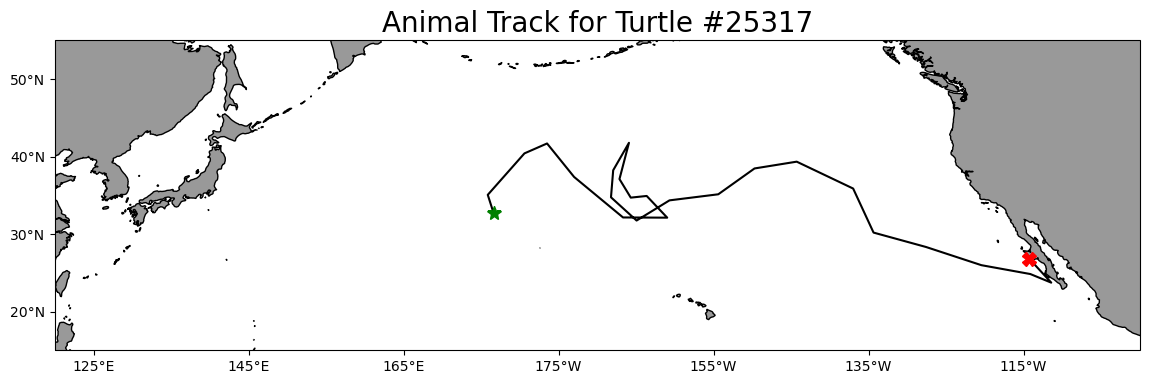

In [9]:
plt.figure(figsize=(14, 10))

# Label axes of a Plate Carree projection with a central longitude of 180:
ax1 = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=180))

# Use the lon and lat ranges to set the extent of the map
# the 120, 260 lon range will show the whole Pacific
# the 15, 55 lat range with capture the range of the data
ax1.set_extent([120, 260, 15, 55], ccrs.PlateCarree())

# set the tick marks to be slightly inside the map extents
ax1.set_xticks(range(125, 255, 20), crs=ccrs.PlateCarree())
ax1.set_yticks(range(20, 60, 10), crs=ccrs.PlateCarree())

# add feature to the map
ax1.add_feature(cfeature.LAND, facecolor='0.6')
ax1.coastlines()

# format the lat and lon axis labels
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

# bring the lon and lat data into a numpy array 
x, y = df.mean_lon.to_numpy(), df.mean_lat.to_numpy()
ax1 = plt.plot(x, y, transform=ccrs.PlateCarree(), color='k')
# start point in green star
ax1 = plt.plot(x[0], y[0],
               marker='*',
               color='g',
               transform=ccrs.PlateCarree(),
               markersize=10)
# end point in red X
ax1 = plt.plot(x[-1], y[-1],
               marker='X',
               color='r',
               transform=ccrs.PlateCarree(),
               markersize=10)
plt.title('Animal Track for Turtle #25317', fontsize=20)

plt.show()

## Prepare track data for use in the ERDDAP data-request URL
To build the ERDDAP data-request URLs, we will need: 
* Dates as strings in a format that ERDDAP can understand, i.e. YYYY-mm-dd.  
* The latitude and longitude values need to be converted to strings (characters) not the numerical values found in the mean_lon and mean_lat columns.  

### Create a formatted date column and change the columns data type 
Let's do that in two steps:  

1. __Reload the "25317_05_subsampled.dat". This time we will use the "parse_dates" option to create a Pandas date object column (year_month_day) from the 'year', 'month', and 'day' columns.__   


In [10]:
df = pd.read_csv('../data/25317_05_subsampled.dat',
                 parse_dates=[['year', 'month', 'day']]
                 )

print('The new year_month_day column contains the Pandas date objects')
df.head(2)


The new year_month_day column contains the Pandas date objects


,year_month_day,mean_lon,mean_lat
0,2005-05-04,176.619433,32.678728
1,2005-06-23,175.860895,35.057734


2. __Use the year_month_day column to create a column called "date_str" containing string versions of the date with the format "YYYY-mm-dd".__  
* Delete the year_month_day column to keep the data frame smaller

In [11]:
df['date_str'] = df['year_month_day'].dt.strftime('%Y-%m-%d')
df

# Clean up the data frame a little by deleting the year_month_day column
del df['year_month_day']
print(df.head(2))

print(' ')
print('The time range is:', df.date_str.min(), df.date_str.max())

     mean_lon   mean_lat    date_str
0  176.619433  32.678728  2005-05-04
1  175.860895  35.057734  2005-06-23
 
The time range is: 2005-05-04 2008-08-16


### Create string versions of the latitude and longitude data 
__Create two new columns (mean_lon_str and mean_lat_str) the have the latitude and longitude coordinates as string data types rather than numerical (float) data types found in columns mean_lon and mean_lat.__  
* The two new columns are mean_lon_str and mean_lat_str

In [12]:
df[['mean_lon_str', 'mean_lat_str']] = df[['mean_lon', 
                                           'mean_lat'
                                          ]].to_numpy(dtype=str)

print(df.head(2))
print(' ')
print('Data types for each column')
print(df.dtypes)


     mean_lon   mean_lat    date_str      mean_lon_str      mean_lat_str
0  176.619433  32.678728  2005-05-04  176.619432886108  32.6787283689241
1  175.860895  35.057734  2005-06-23  175.860895212552   35.057734124614
 
Data types for each column
mean_lon        float64
mean_lat        float64
date_str         object
mean_lon_str     object
mean_lat_str     object
dtype: object


## Extract data from a satellite dataset corresponding to points on the track

We are going to download data from an ERDDAP server using the following steps: 
* Select a dataset
* Loop though the track data using the string versions of data, latitude and longitude to build an ERDDAP data-request URL for each row of the track data frame.
* Use the ERDDAP data-request URL to download satellite data into Pandas
* Add the downloaded data to you track data frame.

### Select a dataset

We'll use the European Space Agency's OC-CCI product (https://climate.esa.int/en/projects/ocean-colour/) to obtain chlorophyll data. This is a merged product combining data from many ocean color sensors to create a long time series (1997-present).


Ideally we would use a daily dataset, selecting the day correspond the the track data date. However, chlorophyll measurements can have lots of missing data, primarily due to cloud cover. To reduce data gaps and improve the likelihood of data for our matchups, we can use a dataset that combines data monthly averages. 

__Let's use data from the monthly version of the OC-CCI datasets.__  
The ERDDAP URLs to the monthly version is below:    
https://oceanwatch.pifsc.noaa.gov/erddap/griddap/esa-cci-chla-monthly-v6-0  

__A note on dataset selection__  
We have preselected the dataset because we know it will work with this exercise. If you were selecting datasets on your own, you would want to check out the dataset to determine if its spatial and temporal coverages are suitable for your application. Following the link above you will find:  

The latitude range is -89.97916 to 89.97916 and the longitude range is 0.020833 to 359.97916, which covers the track latitude range of 23.72 to 41.77 and longitude range of 175.86 to 248.57.  

The time range is 1997-09-04 to 2023-03-01 (at the day of this writing), which covers the track time range of 2005-05-04 to 2008-08-16.  

You should also note the name of the variable you will be downloading. For this dataset it is "__chlor_a__"

### Refresher on building the ERDDAP data-request URL
To refresh your memory from the ERDDAP Tutorial, a full ERDDAP data-request URL looks like the following:
`https://oceanwatch.pifsc.noaa.gov/erddap/griddap/esa-cci-chla-monthly-v6-0.csv?chlor_a[(2023-03-01)][(89.9792):(-89.9792)][(0.02083):(359.9792)]`  

p {
    text-align: justify;

__We can deconstruct the URL into its component parts:__   

| Name | Value | Description | 
| ---: |    :---- | :--- | 
| ERDDAP base URL | __https://oceanwatch.pifsc.noaa.gov/erddap/griddap/__ | Web location of ERDDAP server|
| Dataset ID | __aesa-cci-chla-monthly-v6-0__ | Unique dataset ID |
| Download file | __.csv__ | Data file to download (CSV is this case) |
| Query indicator | __?__ | Mark start of data query |
| Variable | __chlor_a__ | ERDDAP variable to download |
| Time range | __[(2023-02-15):1:(2023-03-01)]__ | Temporal date range to download |
| Latitude range | __[(89.9792):(-89.9792)]__ | Latitude range to download |
| Longitude range | __[(0.02083):(359.9792)]__ | Longitude range to download |  

}

__We need to construct these components parts for each row of the track data frame and join them together to form  the ERDDAP data-request URL.__  


### Building the ERDDAP data-request URL and downloading satellite data

In [13]:
# create a data frame to hold the downloaded satellite data
col_names = ["iso_date", "matched_lat", "matched_lon", "matched_chla"]
tot = pd.DataFrame(columns=col_names)

# create variables for the unchanging parts of the ERDDAP data-request URL. 
base_url = 'https://oceanwatch.pifsc.noaa.gov/erddap/griddap/'
dataset_id = "esa-cci-chla-monthly-v6-0"
file_type = '.csv'
query_start = '?'
erddap_variable = 'chlor_a'

# create the start of the ERDDAP data-request URL by joining URL components
start_url = ''.join([base_url,
                     dataset_id,
                     file_type,
                     query_start,
                     erddap_variable
                     ])


# Finish each URL and download
for i in range(0, len(df)):
 
    # for each row in the track data frame, create the query part of the ERDDAP data-request URL.
    query_url = ''.join([
                         '[(' + df['date_str'][i] + '):1:(' + df['date_str'][i] + ')]',
                         '[(' + df['mean_lat_str'][i] + '):1:(' + df['mean_lat_str'][i] + ')]', 
                         '[(' + df['mean_lon_str'][i] + '):1:(' + df['mean_lon_str'][i] + ')]'
                         ])
    # join the start and query parts of the url
    url = start_url + query_url
    print(i+1, 'of', len(df), url)

    # download the data as a CSV file directly into Pandas
    new = pd.read_csv(url, skiprows=1)
    new.columns = col_names
    
    # load into the holding data frame
    tot = tot.append(new, ignore_index=True)

tot.head(2)

1 of 25 https://oceanwatch.pifsc.noaa.gov/erddap/griddap/esa-cci-chla-monthly-v6-0.csv?chlor_a[(2005-05-04):1:(2005-05-04)][(32.6787283689241):1:(32.6787283689241)][(176.619432886108):1:(176.619432886108)]
2 of 25 https://oceanwatch.pifsc.noaa.gov/erddap/griddap/esa-cci-chla-monthly-v6-0.csv?chlor_a[(2005-06-23):1:(2005-06-23)][(35.057734124614):1:(35.057734124614)][(175.860895212552):1:(175.860895212552)]
3 of 25 https://oceanwatch.pifsc.noaa.gov/erddap/griddap/esa-cci-chla-monthly-v6-0.csv?chlor_a[(2005-08-12):1:(2005-08-12)][(40.4057593651645):1:(40.4057593651645)][(180.592617770427):1:(180.592617770427)]
4 of 25 https://oceanwatch.pifsc.noaa.gov/erddap/griddap/esa-cci-chla-monthly-v6-0.csv?chlor_a[(2005-10-01):1:(2005-10-01)][(41.6848032419466):1:(41.6848032419466)][(183.510212411605):1:(183.510212411605)]
5 of 25 https://oceanwatch.pifsc.noaa.gov/erddap/griddap/esa-cci-chla-monthly-v6-0.csv?chlor_a[(2005-11-20):1:(2005-11-20)][(37.3662285175569):1:(37.3662285175569)][(186.99974658

,iso_date,matched_lat,matched_lon,matched_chla
0,2005-05-01T00:00:00Z,32.6875,176.604167,0.293616
1,2005-07-01T00:00:00Z,35.0625,175.854167,0.114716


### Consolidate the downloaded satellite data into the track data frame

In [14]:

df[['matched_lat', 'matched_lon', 'matched_chla']] = tot[['matched_lat',
                                                          'matched_lon',
                                                          'matched_chla'
                                                          ]]
df.head(2)

,mean_lon,mean_lat,date_str,mean_lon_str,mean_lat_str,matched_lat,matched_lon,matched_chla
0,176.619433,32.678728,2005-05-04,176.619432886108,32.6787283689241,32.6875,176.604167,0.293616
1,175.860895,35.057734,2005-06-23,175.860895212552,35.057734124614,35.0625,175.854167,0.114716


### Save your work

In [15]:
df.to_csv('chl_matchup_turtle25327.csv', index=False, encoding='utf-8')

## Plot chlorophyll matchup data onto a map

### First plot a histogram of the chlorophyll data

Range: 0.05568646 0.7134876


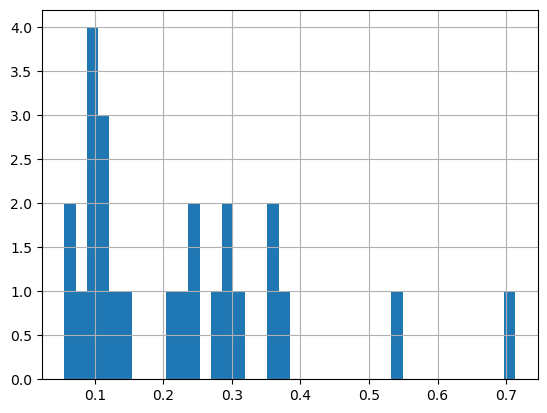

In [16]:
print('Range:', df.matched_chla.min(), df.matched_chla.max())
_ = df.matched_chla.hist(bins=40)

The range of chlorophyll values can be large, with lots of very low values, and a few very high values. This could skew a linear color bar so the most values lower values have the same color.
* For this reason we often plot the log or log10 of chlorophyll 

### Plot a histogram of the log of the chlorophyll data

Range: -2.8880182495708433 -0.3375902213332933


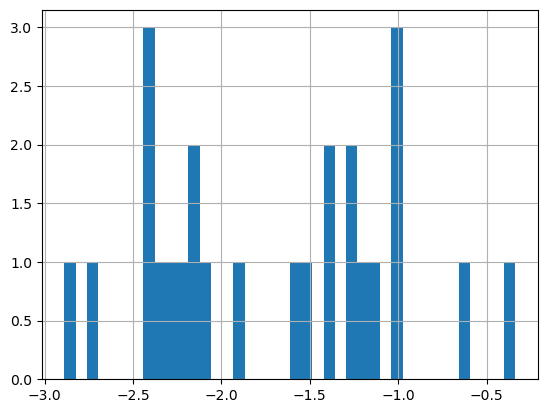

In [17]:
print('Range:', np.log(df.matched_chla.min()), np.log(df.matched_chla.max()))
_ = np.log(df.matched_chla).hist(bins=40)

* The log transformed data is more uniformly distributed (above). 
* The range of log chlorophyll is about -2.9 to -0.3 but most of the values are between -2.5 and -0.8. 
* Knowing the distribution of values can also help to set the color bar range for our map.

### Map the chlorophyll data

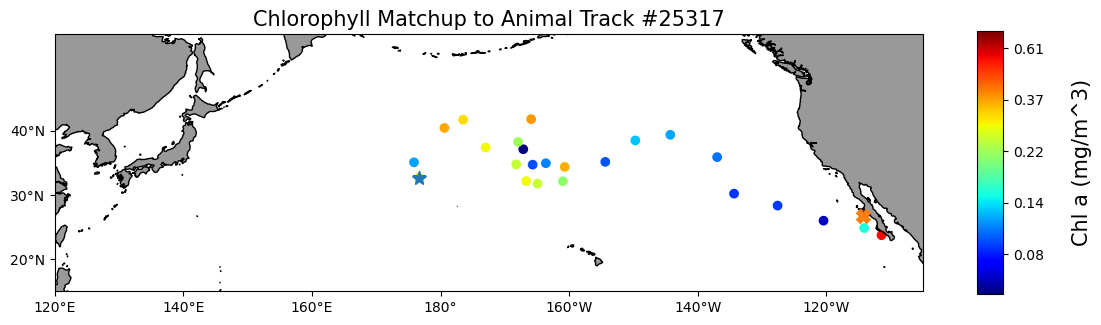

In [18]:
plt.figure(figsize=(14, 10))

# Label axes of a Plate Carree projection with a central longitude of 180:

# set the projection
ax1 = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=180))

# Use the lon and lat ranges to set the extent of the map
# the 120, 260 lon range will show the whole Pacific
# the 15, 55 lat range with capture the range of the data
ax1.set_extent([120,255, 15, 55], ccrs.PlateCarree())

# set the tick marks to be slightly inside the map extents
ax1.set_xticks(range(120,255,20), crs=ccrs.PlateCarree())
ax1.set_yticks(range(20,50,10), crs=ccrs.PlateCarree())

# Add geographical features
ax1.add_feature(cfeature.LAND, facecolor='0.6')
ax1.coastlines()

# format the lat and lon axis labels
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

# build and plot coordinates onto map
x,y = list(df.mean_lon),list(df.mean_lat)
ax1 = plt.scatter(x, y, transform=ccrs.PlateCarree(),
                  marker='o',
                  c=np.log(df.matched_chla),
                  cmap=plt.get_cmap('jet')
                  )
ax1=plt.plot(x[0],y[0],marker='*', transform=ccrs.PlateCarree(), markersize=10)
ax1=plt.plot(x[-1],y[-1],marker='X', transform=ccrs.PlateCarree(), markersize=10)



# control color bar values spacing
levs2 = np.arange(-2.5, 0, 0.5)
cbar=plt.colorbar(ticks=levs2, shrink=0.75, aspect=10)
cbar.set_label("Chl a (mg/m^3)", size=15, labelpad=20)

# set the labels to be exp(levs2) so the label reflect values of chl-a, not log(chl-a)
cbar.ax.set_yticklabels(np.around(np.exp(levs2), 2), size=10)

plt.title("Chlorophyll Matchup to Animal Track #25317", size=15)
plt.show()

## On your own!

##### Exercise 1:
Repeat the steps above with a different dataset.
For example, extract sea surface temperature data using the following dataset:
https://coastwatch.pfeg.noaa.gov/erddap/griddap/nesdisGeoPolarSSTN5NRT_Lon0360.html  
* This dataset is a different ERDDAP, so remember the change the base URL.
* Set the new dataset ID and variable name.


##### Exercise 2:
Go to an ERDDAP of your choice, find a dataset of interest, generate the URL, copy it and edit the script above to run a match up on that dataset.
To find other ERDDAP servers, you can use this search engine:
http://erddap.com/  
* This dataset will likely be on a different ERDDAP, so remember the change the base URL.
* Set the new dataset ID and variable name.
* Check the metadata to make sure the dataset covers the spatial and temporal range of the track dataset. 

##### Optional
Repeat the steps above with a daily version of the OC-CCI dataset to see how cloud cover can reduce the data you retrieve. 
https://oceanwatch.pifsc.noaa.gov/erddap/griddap/CRW_sst_v1_0.html
